In [1]:
import math
import torch
import hess
import matplotlib.pyplot as plt
from hess.nets import Transformer
from hess.data import data_loader
import numpy as np
import sklearn.datasets as datasets

In [2]:
def twospirals(n_points, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [3]:
X, Y = twospirals(500, noise=1.)

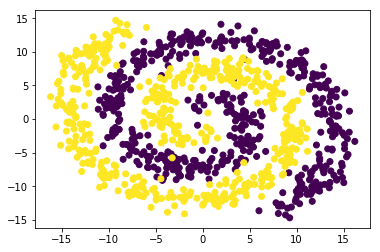

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [5]:
train_x = torch.FloatTensor(X)

In [6]:
train_y = torch.FloatTensor(Y).unsqueeze(-1)

In [7]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(4)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    train_x, train_y = train_x.cuda(), train_y.cuda()

In [8]:
optimus = Transformer(train_x, train_y, net=hess.nets.MoonNet, n_hidden=5, hidden_size=20,
                     activation=torch.nn.ELU(), bias=True)

In [9]:
print(sum(p.numel() for p in optimus.net.parameters()))

1761


In [10]:
if use_cuda:
    optimus = optimus.cuda()

In [11]:
out = optimus(train_x)

/home/greg_b/anaconda3/envs/home/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [12]:
print(out.shape)

torch.Size([1000, 1])


In [13]:
optimus.train_net(print_loss=True, lr=0.01, iters=25,
                 loss_func=torch.nn.BCELoss())

tensor(0.7060, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6834, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6686, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6561, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6586, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6523, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6444, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6441, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6410, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6353, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6336, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6319, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6271, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6227, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6179, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6153, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6075, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6036, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5957, grad_fn=<BinaryCrossEntropyBack

In [14]:
out = optimus(train_x)

In [15]:
out.shape

torch.Size([1000, 1])

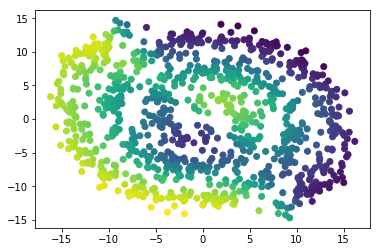

In [16]:
plt.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=out[:, 0].detach().cpu())

## Let's get this bread

In [17]:
import hess.utils as utils

In [18]:
model = optimus.net
par_list = model.parameters()
n_par_w_bias = sum(torch.numel(p) for p in par_list)

In [19]:
n_par_w_bias

1761

In [20]:
e1 = torch.zeros(n_par_w_bias)
e1[0] = 1
e1 = e1.unsqueeze(0)

In [21]:
magic_e1 = utils.unflatten_like(e1, model.parameters())
if use_cuda:
    magic_e1 = [t.cuda() for t in magic_e1]

In [22]:
utils.eval_hess_vec_prod(magic_e1, model.parameters(), 
                         net=optimus.net,
                         criterion=torch.nn.MSELoss(), 
                         inputs=train_x, targets=train_y)

In [23]:
output = utils.gradtensor_to_tensor(optimus.net, include_bn=True)

In [24]:
output.nelement()

1761

In [25]:
base_vec = torch.zeros(n_par_w_bias).cpu().unsqueeze(0)
base_vec[0, 0] = 1.

base_vec = utils.unflatten_like(base_vec, model.parameters())
utils.eval_hess_vec_prod(base_vec, model.parameters(),
                        net=optimus.net.cpu(),
                        criterion=torch.nn.MSELoss(),
                        inputs=train_x.cpu(), targets=train_y.cpu())
output = utils.gradtensor_to_tensor(optimus.net.cpu(), include_bn=True)

n_par = output.nelement()

In [26]:
n_par

1761

In [27]:
hessian = torch.zeros(n_par, n_par).cpu()
for pp in range(n_par):
    base_vec = torch.zeros(n_par_w_bias).cpu().unsqueeze(0)
    base_vec[0, pp] = 1.
    
    base_vec = utils.unflatten_like(base_vec, model.parameters())
    utils.eval_hess_vec_prod(base_vec, model.parameters(),
                            net=optimus.net.cpu(),
                            criterion=torch.nn.MSELoss(),
                            inputs=train_x.cpu(), targets=train_y.cpu())
    if pp == 0:
        output = utils.gradtensor_to_tensor(optimus.net, include_bn=True)
        hessian = torch.zeros(output.nelement(), output.nelement())
        hessian[:, pp] = output
    hessian[:, pp] = utils.gradtensor_to_tensor(optimus.net.cpu(), include_bn=True).cpu()

KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
e_val, e_vec = np.linalg.eig(hessian.cpu())
idx = np.abs(e_val).argsort()[::-1]   
e_val = torch.FloatTensor(e_val[idx].real)
e_vec = torch.FloatTensor(e_vec[:,idx].real)

In [ ]:
ne = e_val.div(torch.sum(e_val))
plt.plot(np.cumsum(ne[:50].cpu()), marker=".")

In [ ]:
plt.plot(np.log(np.abs(e_val)))

## Save model to use on laptop

In [ ]:
torch.save(optimus.net.state_dict(), "../hess/saved-models/spirals.pt")
saved_pars = optimus.net.state_dict()

In [ ]:
torch.save(hessian, "../hess/saved-models/spirals_hessian.pt")

## Do Some Perturbing

In [ ]:
torch.set_default_tensor_type(torch.FloatTensor)
optimus = optimus.cpu();

In [ ]:
from hess.plotting import plot_decision_boundary

In [ ]:
plot_decision_boundary(train_x, train_y, optimus, use_cuda=False,
                      buffer=0.5, h=0.1)

## Average Over Large Curvature Perturbations

In [ ]:
buffer = 0.5
h = 0.1
x_min, x_max = train_x[:, 0].min() - buffer, train_x[:, 0].max() + buffer
y_min, y_max = train_x[:, 1].min() - buffer, train_x[:, 1].max() + buffer

xx,yy=np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h), 
                  np.arange(y_min.cpu(), y_max.cpu(), h))
in_grid = torch.FloatTensor([xx.ravel(), yy.ravel()]).t()

In [ ]:
n_vec = 3
scale = 0.0
basis = e_vec[:, :n_vec]
n_trial = 1
pred = torch.zeros(in_grid.size(0), n_trial).cpu()
for tt in range(n_trial):
    optimus.net.load_state_dict(saved_pars)
    wghts = torch.randn(n_vec).cpu()
    perturb = basis.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)

    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
        
    pred[:, tt] = optimus.net(in_grid, temp=1.).squeeze().cpu()

In [ ]:
avg_pred = pred.mean(1).detach().numpy().reshape(xx.shape)

In [ ]:
plt.figure(figsize=(15, 10))
plt.contourf(xx, yy, avg_pred, alpha=0.5)
# plt.title("Temp Scaled", fontsize=24)
plt.colorbar()
plt.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary)

## Small Curvature

In [ ]:
n_vec = 3
scale = 0.5
basis = e_vec[:, -n_vec:]
n_trial = 1
pred = torch.zeros(in_grid.size(0), n_trial).cpu()
for tt in range(n_trial):
    optimus.net.load_state_dict(saved_pars)
    wghts = torch.randn(n_vec).cpu()
    perturb = basis.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scale)

    perturb = utils.unflatten_like(perturb, optimus.net.parameters())
    for i, par in enumerate(optimus.net.parameters()):
        par.data = par.data + perturb[i]
        
    pred[:, tt] = optimus(in_grid).squeeze().cpu()

In [ ]:
avg_pred = pred.mean(1).detach().numpy().reshape(xx.shape)

In [ ]:
plt.figure(figsize=(15, 10))
plt.contourf(xx, yy, avg_pred, alpha=0.5)
plt.title("Avg. Perturbed", fontsize=24)
plt.colorbar()
plt.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary)